# Importations et chargement des données

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from joblib import dump
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import numpy as np
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn import metrics
from imblearn.over_sampling import SMOTENC
from preprocessing_functions import preprocess_data, load_joblibs, drop_outliers_all
from matplotlib.gridspec import GridSpec
from collections import Counter
from sklearn.neural_network import MLPClassifier

In [2]:
onehot_encoder, label_encoders, mean_imputer, freq_imputer, scaler = load_joblibs(
    './joblib')

In [3]:
# data_dir: Répertoire contenant les bases de données
data_dir = 'home-credit-default-risk'
app = pd.read_csv(data_dir + '/application_train_preprocessed.csv')

In [4]:
prev_app = pd.read_csv(data_dir + '/previous_application.csv')

# Préparation des données

On sépare la cible à prédire de notre table:

In [5]:
# target: Variable à prédire
target = app['TARGET']
app.drop(columns=['TARGET'], inplace=True)

In [6]:
app = app.set_index('SK_ID_CURR')

On sépare nos données de test de nos données d'entraînement.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(app, target, train_size=0.8, random_state=0)

On s'assure que les indices des données d'entraînement correspondent:

In [8]:
X_train.index = pd.Index(np.arange(0,len(X_train)))
y_train.index = pd.Index(np.arange(0,len(y_train)))

On supprime les outilers dans les entrées et les sorties des données d'entraînement:

In [9]:
drop_outliers_all(X_train, mean_imputer.feature_names_in_, n_iqr=5)
y_train.drop(index=y_train.index[~y_train.index.isin(X_train.index)], inplace=True)

In [10]:
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()

In [11]:
print("Notre échantillon d'entraînement contient %d individus avec %d variables" % (len(X_train), len(X_train[0])))

Notre échantillon d'entraînement contient 215312 individus avec 39 variables


# Fonctions

## Scoring

Pour évaluer la performance, on a deux possibilités:
- La métrique technique: **L'AUC**
- La métrique métier: **Le score F_beta** - qui prend en compte la différence entre le coût et le gain d'un crédit.

Pour le score F_beta, on fait l'hypothèse pessimiste que lorsqu'un client a un défaut de paiement, il ne rembourse même pas en partie son crédit.

In [12]:
# med_interest_rate: Taux d'intérêt médian
med_interest_rate = prev_app['RATE_INTEREST_PRIMARY'].median()
# beta_recall: Coefficient à appliquer à la sensibilité dans le score F_beta
beta_recall = int(1/med_interest_rate)+1
print("Le coût d'un défaut de paiement représent %d fois le gain grâce au taux d'intérêt" % beta_recall)

Le coût d'un défaut de paiement représent 6 fois le gain grâce au taux d'intérêt


In [13]:
def auc_score(estimator, X_test, y_test):
    y = estimator.predict_proba(X_test)[:, 1]
    return metrics.roc_auc_score(y_test, y)


In [14]:
def fbeta_score(estimator, X_test, y_test, beta=beta_recall):
    y = estimator.predict(X_test)
    return metrics.fbeta_score(y_test, y, beta=beta)

## Évaluation des performances

In [15]:
def prediction_performance(classifier, X_train, y_train, X_test, y_test, subtitle="", roc_plot=True, calibration_plot=True):
    """
    Fonction permettant d'évaluer la performance d'un classificateur. Affiche la courbe ROC avec l'AUC, le précision,
    la spécifité et le score fbeta. Affiche aussi la courbe de fiabilité.
    Retourne l'ensemble des métriques calculées.
    """
    # y_proba: Probabilités de défaut de paiement prédites pour les données d'entraînement
    y_proba = classifier.predict_proba(X_train)[:,1]
    # fpr, tpr, thresholds: False Positive Rate, True Positive Rate, Seuils, pour les données d'entraînement
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_proba, pos_label=1)
    # best_tresh: Seuil optimal pour discriminer les candidatures
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    print("Seuil optimal de discrimination:%f" % best_thresh)
    # y_proba: Probabilités de défaut de paiement prédites pour les données de test
    y_proba = classifier.predict_proba(X_test)[:,1]
    # y_pred: Labels de la classe en fonction des probabilités prédites
    y_pred = np.zeros((len(y_proba),))
    y_pred = np.where(y_proba>=best_thresh, 1, y_pred)
    # fpr, tpr, thresholds: False Positive Rate, True Positive Rate, Seuils, pour les données de test
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba, pos_label=1)
    # auc: Area Under Curve
    auc = metrics.auc(fpr, tpr)
    # recall: Sensibilité
    recall = metrics.recall_score(y_test, y_pred, average='binary', pos_label=1)
    # recall: Spécifité
    precision = metrics.precision_score(y_test, y_pred)
    # fbeta: Score f_beta, en prenant le beta adapté au taux d'intérêt médian
    fbeta = metrics.fbeta_score(y_test, y_pred, beta=beta_recall)
    fig = plt.figure(figsize=(14, 5))
    gs = GridSpec(nrows=1, ncols=2, wspace=0.25)
    if roc_plot:  # Code affichant la courbe ROC
        ax0 = fig.add_subplot(gs[0,0])
        ax0.plot([0,1], [0,1], linestyle='--')
        plt.title("Receiver Operating Characteristic%s" % subtitle)
        plt.plot(fpr, tpr)
        plt.text(0.6, 0.4, "AUC=%.3f\nSensitivity=%.3f\nSpecifity=%.3f\nFbeta=%.3f" % (auc, recall, precision, fbeta))
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
    if calibration_plot:  # Code affichant la courbe de fiabilité
        ax1 = fig.add_subplot(gs[0,1]) 
        fraction_positives, mean_proba = calibration_curve(y_test, y_proba)
        ax1.plot(mean_proba, fraction_positives)
        ax1.plot([0,1], [0,1], linestyle='--')
        plt.title("Calibration curve")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of positives")
    return auc, recall, precision, fbeta

## Importance des features

In [16]:
def plot_coef_features(coefs, features, algo_name, abs_min_coef=0):
    """
    Affiche l'importance des features dans un histogramme. Si les importances sont négatives, les barres sont rouges.
    Autrement, elles sont bleues."""
    # coef_feature: Liste des (varible, importance) triés par importance
    coef_feature = np.array([(feature, float(coef)) for feature, coef in zip(features, coefs)])
    coef_feature = coef_feature[[abs(float(coef))>=abs_min_coef for feature, coef in coef_feature]]
    coef_feature = coef_feature.tolist()
    coef_feature.sort(key=lambda x: float(x[1]))
    # coef_pos, coef_neg: coef_feature, où on remplace les coefficients négatifs ou positifs, selon la liste, par 0 
    coef_pos, coef_neg = [], []
    for feature, coef in coef_feature:
        coef = float(coef)
        if coef >= 0:
            coef_pos.append((feature, coef))
            coef_neg.append((feature, 0))
        else:
            coef_neg.append((feature, abs(coef)))
            coef_pos.append((feature, 0))
    coef_pos, coef_neg = np.array(coef_pos), np.array(coef_neg)
    plt.figure(figsize=(9, 6))
    plt.bar(coef_pos[:,0], np.array(coef_pos[:,1], dtype=float))
    plt.bar(coef_neg[:,0], np.array(coef_neg[:,1], dtype=float), color='r')
    plt.xlabel("Feature", fontsize=14)
    plt.ylabel("Coefficient", fontsize=14)
    plt.title("Coefficients de %s" % algo_name, fontsize=16)
    plt.legend(['Coefficients > 0', 'Coefficients < 0'])
    _ = plt.xticks(rotation=90)

# Équilibrage des données par duplication

## Calcul des poids

In [17]:
# count: Dictionnaire contant le nombre de cas positifs et le nombre de cas négatifs
count = Counter(y_train)
# weight_positive: Poids à accorder aux cas positifs
weight_positive=count[0]/count[1]
print("Il y à %.2f cas négatifs pour 1 cas positif" % weight_positive)
weight_positive = int(round(weight_positive))

Il y à 10.87 cas négatifs pour 1 cas positif


## Régression logistique   
Ici, le seul hyperparamètre est le coefficient de la régularisation. Comme on s'est déjà assuré que nos variables ne sont pas fortement corrélées, la régularisation n'apportera rien à notre modèle. On a donc pas d'hyperparamétrage à faire.

### Performances

In [18]:
lr = LogisticRegression(solver='liblinear', class_weight={1:weight_positive, 0:1}, random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 11}, random_state=0,
                   solver='liblinear')

Seuil optimal de discrimination:0.491582


/home/ilyes/OC/P7/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


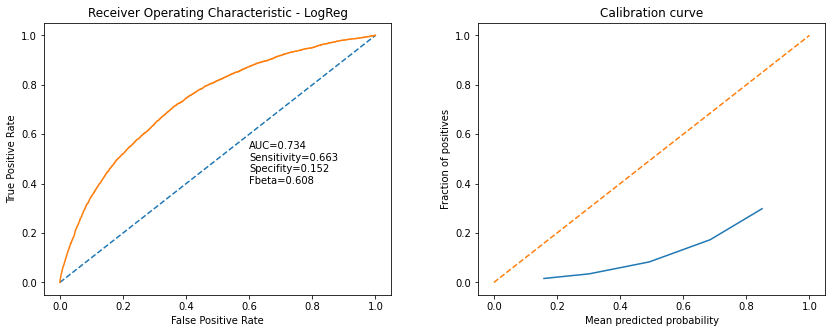

In [19]:
auc_lr, recall_lr, precision_lr, fbeta_lr = prediction_performance(lr, X_train, y_train, X_test, y_test, subtitle=" - LogReg")

## Classificateur avec forêt aléatoire

### Hyper-paramétrage

In [24]:
params = {'n_estimators':[50, 100, 200], 'max_depth': [5, 10, 30], 'class_weight':[{1:weight_positive, 0:1}], 'random_state':[0]}

Voyons les paramètres optimisant le score F_beta:

In [25]:
grid_rforest = GridSearchCV(RandomForestClassifier(), params, scoring=auc_score, cv=3)
_ = grid_rforest.fit(X_train, y_train)

In [26]:
grid_rforest.best_params_

{'class_weight': {1: 11, 0: 1},
 'max_depth': 10,
 'n_estimators': 200,
 'random_state': 0}

On constate qu'ils sont les mêmes, on aura donc qu'un modèle à évaluer.

### Performances

Seuil optimal de discrimination:0.475955


/home/ilyes/OC/P7/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


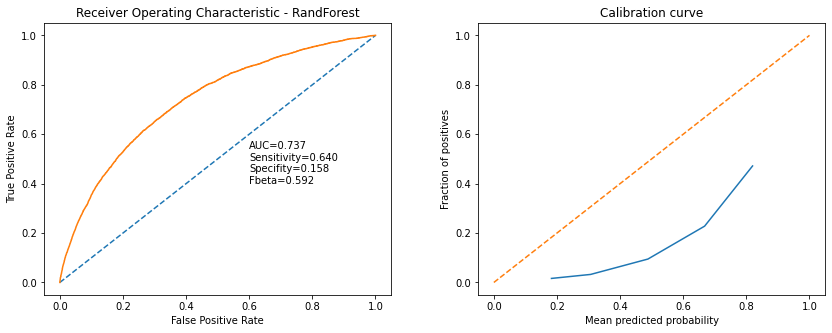

In [27]:
rand_forest = RandomForestClassifier(**(grid_rforest.best_params_))
rand_forest.fit(X_train, y_train)
auc_rf, recall_rf, precision_rf, fbeta_rf = prediction_performance(rand_forest, X_train, y_train, X_test, y_test, subtitle=" - RandForest")

## MLPClassifier

Meilleurs hyper-paramètres pour l'AUC:

In [28]:
params = {'activation':['logistic'], 'hidden_layer_sizes': [(60,), (100,), (30,30,)], 'learning_rate_init':[0.1, 0.01, 0.001], 'random_state':[0]}

Meilleurs hyper-paramètres pour le score F_beta:  TODO

In [29]:
grid_mlp = GridSearchCV(MLPClassifier(), params, scoring=fbeta_score, cv=3)
_ = grid_mlp.fit(X_train, y_train)

/home/ilyes/OC/P7/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ilyes/OC/P7/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ilyes/OC/P7/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Seuil optimal de discrimination:0.091786


/home/ilyes/OC/P7/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


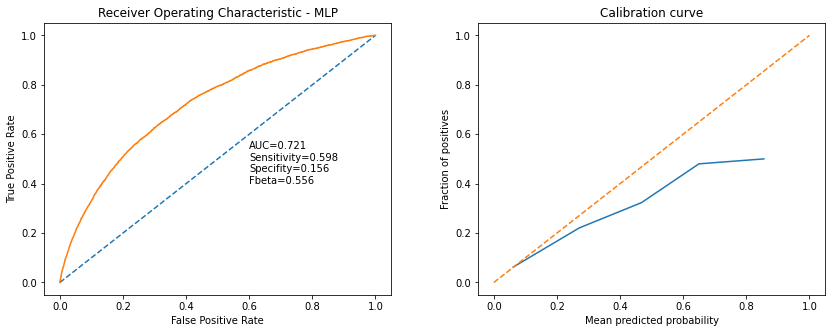

In [30]:
mlp_fbeta = MLPClassifier(**(grid_mlp.best_params_))
mlp_fbeta.fit(X_train, y_train)
auc_mlp, recall_mlp, precision_mlp, fbeta_mlp = prediction_performance(mlp_fbeta, X_train, y_train, X_test, y_test, subtitle=" - MLP")

## Adaboost

In [18]:
params = {'n_estimators': [30, 50, 100], 'learning_rate':[1, 0.1, 0.01], 'random_state':[0]}

In [20]:
grid_ada = GridSearchCV(AdaBoostClassifier(), params, scoring=fbeta_score, cv=3)
_ = grid_ada.fit(X_train, y_train)

In [21]:
grid_ada.best_params_

{'learning_rate': 1, 'n_estimators': 100, 'random_state': 0}

Seuil optimal de discrimination:0.493847


/home/ilyes/OC/P7/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


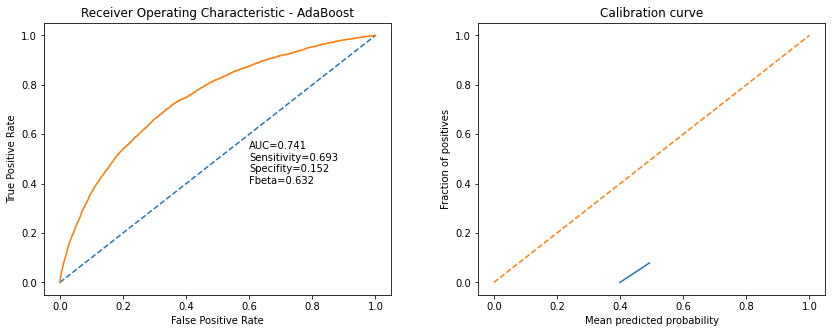

In [26]:
ada_fbeta = AdaBoostClassifier(**(grid_ada.best_params_))
ada_fbeta.fit(X_train, y_train)
auc_ada, recall_ada, precision_ada, fbeta_ada = prediction_performance(ada_fbeta, X_train, y_train, X_test, y_test, subtitle=" - AdaBoost")

In [ ]:
ada_fbeta = AdaBoostClassifier(**(grid_ada.best_params_))
ada_cal = CalibratedClassifierCV(ada_fbeta)
ada_cal.fit(X_train, y_train)
auc_ada, recall_ada, precision_ada, fbeta_ada = prediction_performance(ada_cal, X_train, y_train, X_test, y_test, subtitle=" - AdaBoost")

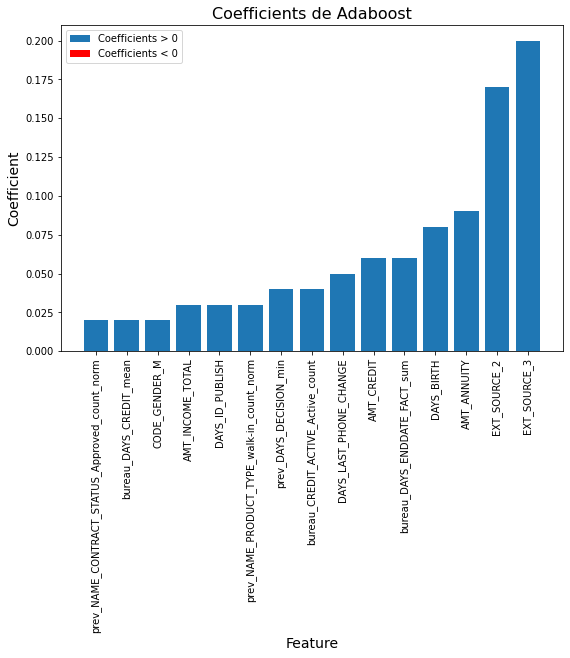

In [27]:
coef_feature = [(float(coef), feature) for coef, feature in zip(ada_fbeta.feature_importances_, app.columns)]
coef_feature.sort(key=lambda x:abs(x[0]), reverse=True)
coef_feature = coef_feature[:15]
coef_feature.sort(key=lambda x:x[0])
coefs = [tup[0] for tup in coef_feature]
features = [tup[1] for tup in coef_feature]
plot_coef_features(coefs, features, "Adaboost")


In [28]:
dump(ada_fbeta, './joblib/adaboost.joblib')

['./joblib/adaboost.joblib']

# Équilibrage des données par ré-échantillonage

## Sur-échantillonage avec SMOTENC

In [23]:
names_quali = freq_imputer.feature_names_in_
names_quali = [name for name in names_quali if name in app.columns]

In [24]:
is_categorical = [col in names_quali for col in app.columns]
smotenc = SMOTENC(random_state=0, categorical_features=is_categorical, sampling_strategy=1.)
X_train_over, y_train_over = smotenc.fit_resample(X_train, y_train)

On teste le ré-échantillonnage avec le modèle choisi

Seuil optimal de discrimination:0.498235


/home/ilyes/OC/P7/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


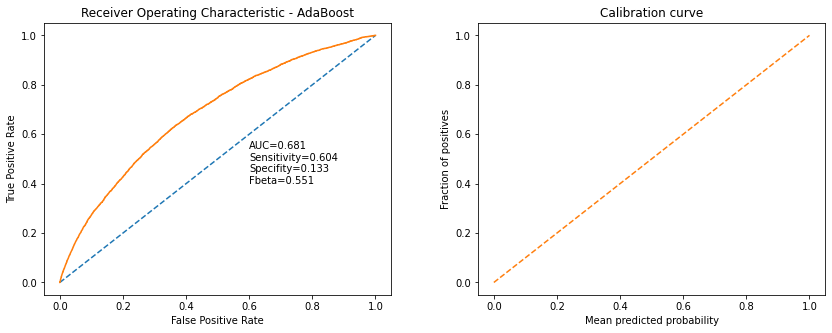

In [25]:
ada_fbeta = AdaBoostClassifier(**(grid_ada.best_params_))
ada_fbeta.fit(X_train_over, y_train_over)
auc_ada, recall_ada, precision_ada, fbeta_ada = prediction_performance(ada_fbeta, X_train, y_train, X_test, y_test, subtitle=" - AdaBoost")